In [1]:
"""
The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6

Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B
"""

'\nThe dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:\n\nBuilding: #3C1098\nLand (unpaved area): #8429F6\n\nRoad: #6EC1E4\nVegetation: #FEDD3A\nWater: #E2A929\nUnlabeled: #9B9B9B\n'

In [2]:
#import tensorflow as tf
# tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)
#import gc

In [4]:
import os
import cv2
import numpy as np

!pip install patchify
!pip install segmentation_models
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Segmentation Models: using `keras` framework.


In [5]:

root_directory = '/content/drive/MyDrive/Semantic segmentation dataset/'

patch_size = 256


In [6]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

In [8]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image) 

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

/content/drive/MyDrive/Semantic segmentation dataset/
/content/drive/MyDrive/Semantic segmentation dataset/Tile 7
/content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images/image_part_009.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/images/image_par

In [9]:
#del SIZE_X, SIZE_Y, dirname, files, i, image, image_name, images, j, patches_img, path, single_patch_img, subdirs
#gc.collect()

In [10]:
#import sys 
#ys.version

In [20]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_008.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_006.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_005.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_001.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_002.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_009.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_003.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_004.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks/image_part_007.png
Now patchifying mask: /content/drive/

In [21]:
#del SIZE_X, SIZE_Y, dirname, files, i, j, mask, mask_name, masks, patches_mask, path, subdirs
#gc.collect()

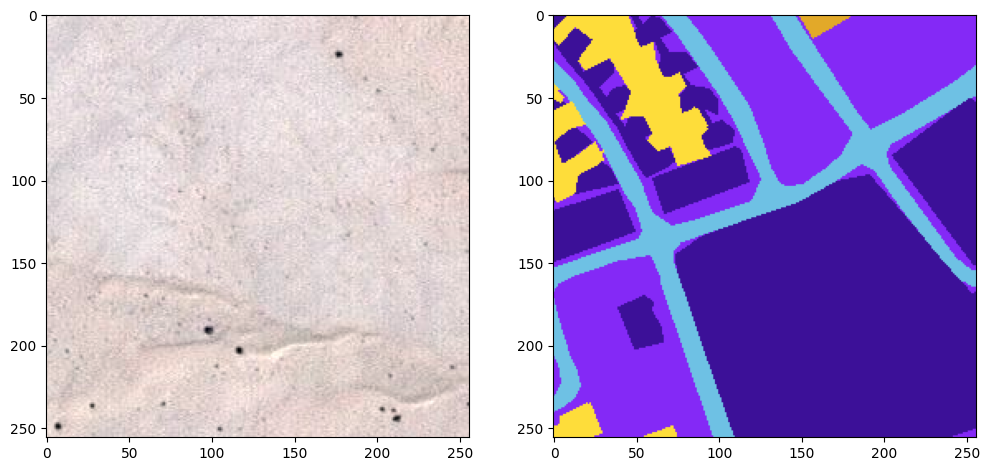

In [22]:

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [23]:


#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 

Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [24]:
# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# If matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our label masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))



Unique labels in label dataset are:  [0 1 2 3 4 5]


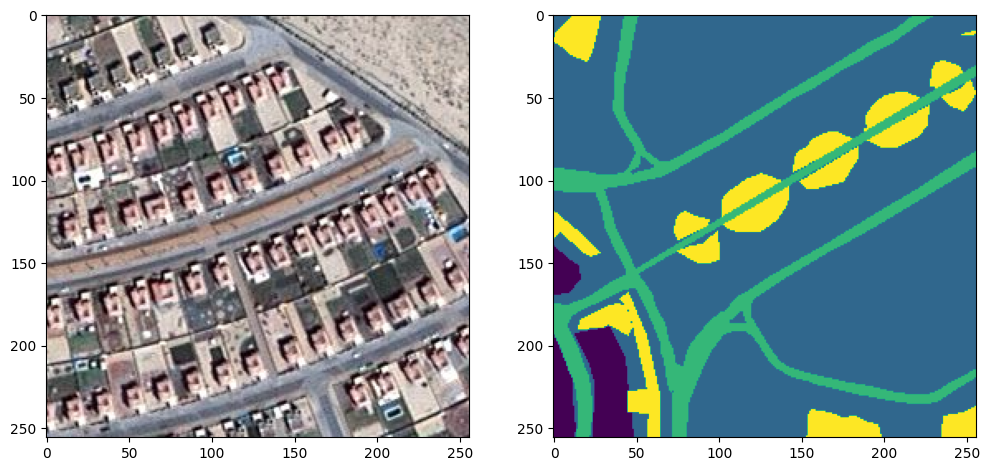

In [26]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [25]:

############################################################################


n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)




In [ ]:
#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
!cp -r "/content/drive/MyDrive/Colab Notebooks/simple_multi_unet_model.py" '/content/'



from simple_multi_unet_model import multi_unet_model, jacard_coef  
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhos

In [ ]:
#with tf.device('/GPU:0'):
history1 = model.fit(X_train, y_train, 
                      batch_size = 8, 
                      verbose=1, 
                      epochs=100, 
                      validation_data=(X_test, y_test), 
                      shuffle=False)